##POKER PLAYING AGENTS
Group 18 \
Leonidas Bakopoulos AM 2018030036 \
Alexandra Tsipouraki AM 2018030089


To execute the code, run all the cells in the order they are displayed below (press Runtime -> Run all from the main Colab menu)

##Plotting
To produce and see ALL the plots that are shown in the report please run our main.py file in VS Code but for all the possible values(True or False) of these parameters (last lines of our main in google colab too) :  
    q_learning = True #Use a q-learning agent or not\
    threshold = True #Use a threshold or a random opponent \
    aggressive = True#in case of threshold, use aggressive or\ defensive opponent

Then run plotting.py from the 'project' folder

To play against Q-learning please set train = False

In [55]:
!mkdir ./data

mkdir: cannot create directory ‘./data’: File exists


In [56]:
!mkdir ./images

mkdir: cannot create directory ‘./images’: File exists


#Agents cell
The code below can be also found in : agent.py, implemented_agents.py


In [57]:
import numpy as np
import sys
class Agent:
    def __init__(self):

        pass

    def send_action(self, state):
        return NotImplemented

    def to_str(self):
        return "Agent"
    def reduce_a(self):
        pass


class PolicyIterationAgent(Agent):
    def __init__(self,P, epsilon = 10**(-4), gamma=.9):
        self.P = P #Transition Matrix
        self.epsilon = epsilon #conergence criterion
        self.gamma = gamma
        self.pi = None #initial policies
        self.V = None #initial V
        self.V, self.pi = self.policy_iteration(self.gamma) #converged policies and V
        return


    def send_action(self, state):
        """
        Method that every agent inherits.
        Is used by agent, for deciding the best action
        """
        return  self.pi(state)

    def policy_evaluation(self, pi = None):
        self.pi = pi if pi is not None else self.pi
        prev_V = np.zeros(len(self.P)) # use as "cost-to-go", i.e. for V(s'):
        while True:
            V = np.zeros(len(self.P)) # current value function to be learnerd
            for s in range(len(self.P)):  # do for every state

                for prob, next_state, reward, done in self.P[s][self.pi(s)]:  # calculate one Bellman step --> i.e., sum over all probabilities of transitions and reward for that state, the action suggested by the (fixed) policy, the reward earned (dictated by the model), and the cost-to-go from the next state (which is also decided by the model)
                    V[s] += prob * (reward + self.gamma * prev_V[next_state] * (not done))
            if np.max(np.abs(prev_V - V)) < self.epsilon: #check if the new V estimate is close enough to the previous one;
                break
            prev_V = V.copy() #freeze the new values (to be used as the next V(s'))

        self.V = V
        return

    def policy_improvement(self, gamma=1.0):  # takes a value function (as the cost to go V(s')), a model, and a discount parameter
        Q = np.zeros((len(self.P), len(self.P[0])), dtype=np.float64) #create a Q value array
        for s in range(len(self.P)):        # for every state in the environment/model
            for a in range(len(self.P[s])):  # and for every action in that state
                for prob, next_state, reward, done in self.P[s][a]:  #evaluate the action value based on the model and Value function given (which corresponds to the previous policy that we are trying to improve)
                    Q[s][a] += prob * (reward + gamma * self.V[next_state] * (not done))
        new_pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]  # this basically creates the new (improved) policy by choosing at each state s the action a that has the highest Q value (based on the Q array we just calculated)

        self.pi = new_pi
        return new_pi

    def policy_iteration(self, gamma):
        t = 0
        random_actions = np.random.choice(tuple(self.P[0].keys()), len(self.P))     # start with random actions for each state
        self.pi = lambda s: {s:a for s, a in enumerate(random_actions)}[s]     # and define your initial policy pi_0 based on these action (remember, we are passing policies around as python "functions", hence the need for this second line)

        while True:
            old_pi = {s: self.pi(s) for s in range(len(self.P))}  #keep the old policy to compare with new
            self.policy_evaluation()   #evaluate latest policy --> you receive its converged value function
            self.pi = self.policy_improvement(gamma=gamma)          #get a better policy using the value function of the previous one just calculated

            t += 1

            if old_pi == {s:self.pi(s) for s in range(len(self.P))}: # you have converged to the optimal policy if the "improved" policy is exactly the same as in the previous step
                break
        print('converged after %d iterations' %t) #keep track of the number of (outer) iterations to converge
        return self.V,self.pi


class Q_Learning_Agent(Agent):

    def __init__(self, state_size, action_size=3, a = .2, gamma = 1.0, seed = 0, Q=None, eps=1, against_human = False):
        """
        There are two ways to initialize the Q_Learning_Agent
        a) By not given an pre-trained Q (and the goal is to create it)
        b) By given a pre-trained Q (and the goal is to test it)
        """
        np.random.seed(seed=seed)
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.a = a

        if Q is not None:self.Q = Q
        else: self.Q = np.random.rand(self.state_size, self.action_size)

        self.conv = 0
        self.eps = eps
        self.disp = True

        self.against_human  = against_human #means that the agent is in testing mode

    def train(self, tuple):
        """
            The most basic method of the Q-Agent.
            In this method, the training is implemented
            based on the previous tuple (knowledge)
        """

        old_q = list([np.argmax(i) for i in self.Q]) #in order to check for convergance
        state, prev_action, reward, next_state,  done = tuple
        if not prev_action is None: #it is None when the agent talks first
            target = reward + self.gamma*np.argmax(self.Q[next_state])*(not done) #bellman equastion
            self.Q[state, prev_action]= (1-self.a)*self.Q[state, prev_action] + self.a*target #learn with learning rate = a

        #convergences stuff
        if(self.check_if_convergence(old_q)):self.conv += 1
        else: self.conv = 0
        if  (self.conv == 10_000):
            print(old_q)
        return (self.conv == 10_000)


    def check_if_convergence(self, old_q):
        """
            Method that compares two instances of policies
        """
        new_q = list([np.argmax(i) for i in self.Q])
        for i,j in zip(old_q,new_q):
            if(i!=j):return False
        return True


    def send_action(self, state):
        """
        Method that every agent inherits.
        Is used by agent, for deciding the best action.
        In this case, an epsilon greedy algorithm is used,
        in order to achieve exploration and exploitation
        """

        self.eps = max(0.9999749*self.eps, .01) #was choosen experimentally, in oder to achieve .01 in 26% of
        #the horizon in episodes against threshold(s) opponent(s)

        if self.against_human: #In order of pretained
            self.eps = .001



        if self.eps < .0101 and self.disp:
            print("eps = .01------------")
            self.disp = False
        p = np.random.rand()

        #select action
        if p < self.eps: #make a random move
            action = np.random.choice([0,1,2])
        else : #act as q suggests
            action = np.argmax(self.Q[state,:])

        #previous bug.
        #It was fixed (we can see that nothing is pinted) but wasn't deleted for safety reasons
        if ((not (action in [0,1,2])) and ( action is not None)):
            print("bug needs to be fixed")
            return np.random.choice([0,1,2])
        return action

    def to_str(self):
        return "Q_Learning_Agent"

    def reduce_a(self):
        """ reducing the learning rate, as it is mentioned in report"""
        self.a = min(0.99998*self.a, 0.12)


class Random_Agent(Agent):
    def __init__(self, seed = 0):
        np.random.seed(seed = seed)

    def send_action(self, state):
        """ the extra arguments, are not used
            They are completed just for constistency
        """
        return np.random.randint(0,3)



class Threshold_Agent_D(Agent):
    """
    This is the tight opponent
    """
    def set_hand(self, hand):
        self.hand = hand
    def set_table(self, table):
        self.table = table
    def set_round(self, round):
        self.round = round
    def send_action(self, state):

        cards_and_actions_round_0 = {
            "T": 1,
            "J": 1,
            "Q":0,
            "K":0,
            "A": 2
        }

        #in preflop just act based on the rank of your hand
        if self.round == 0:
            return cards_and_actions_round_0.get(self.hand.rank, 0) #by default check
        #in flop, action is based on the combination
        for card in self.table:
            if card.rank == self.hand.rank: return 2
        #if no combination in the flop, fold
        return 1


class Threshold_Agent_A(Threshold_Agent_D):
    """
    This is the loose opponent
    """
    def send_action(self, state):

        cards_and_actions_round_0 = {
            "T": 0,
            "J": 0,
            "Q":2,
            "K":2,
            "A": 2
        }
        #in preflop just act based on the rank of your hand
        if self.round == 0:
            return cards_and_actions_round_0.get(self.hand.rank, 0) #by default check
        #in flop, action is based on the combination
        for card in self.table:
            if card.rank == self.hand.rank: return 2
        #if no combination in the flop, check
        return 0

class Human_Agent(Agent):
    """
    Agent for testing purposes.
    This agent, implements the inteface between
    the python code and the tester
    """

    def __init__(self, action_size, threshold = False, ante = False):
        self.action_size = action_size
        self.disp = True
        self.threshold = threshold
        self.ante=ante

    def set_hand(self, hand):
        self.hand = hand


    def set_table(self, table):
        self.table = table

    def set_round(self, round):
        self.round = round

    def interface_display(self):
        print(f"My current hand is : {self.hand}")
        if not( self.table[0].rank == '-1'):
            print(f"The table has :{self.table[0].rank} , {self.table[1].rank}")
        print(f"We are playing round number {self.round} of the game")

    def send_action(self, state):
        # Implement the logic to receive the action from the human player
        # Return the selected action
        self.interface_display()
        valid_actions = [0, 1, 2]
        while True:
            action = input("Enter your action (for quitting press q): Press 0 to 'check' or 'call', 1 to 'fold' and 2 to 'raise': ")
            if action.isdigit() and int(action) in valid_actions:
                return int(action)
            elif action.lower() == 'q':
                sys.exit(0)
            else:
                 print("Invalid input. Please enter a valid action.")




#Card

In [58]:
''' Game-related base classes
'''
class Card:
    '''
    Card stores the suit and rank of a single card

    Note:
        The suit variable in a standard card game should be one of [S, H, D, C, BJ, RJ] meaning [Spades, Hearts, Diamonds, Clubs, Black Joker, Red Joker]
        Similarly the rank variable should be one of [A, 2, 3, 4, 5, 6, 7, 8, 9, T, J, Q, K]
    '''
    suit = None
    rank = None
    valid_suit = ['S', 'H', 'D', 'C', 'BJ', 'RJ']
    valid_rank = ['-1','A', '2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K']

    def __init__(self, suit, rank):
        ''' Initialize the suit and rank of a card

        Args:
            suit: string, suit of the card, should be one of valid_suit
            rank: string, rank of the card, should be one of valid_rank
        '''
        self.suit = suit
        self.rank = rank

    def __eq__(self, other):
        if isinstance(other, Card):
            return self.rank == other.rank
        else:
            # don't attempt to compare against unrelated types
            return NotImplemented

    def __hash__(self):
        suit_index = Card.valid_suit.index(self.suit)
        rank_index = Card.valid_rank.index(self.rank)
        return rank_index + 100 * suit_index

    def __str__(self):
        ''' Get string representation of a card.

        Returns:
            string: the combination of rank and suit of a card. Eg: AS, 5H, JD, 3C, ...
        '''
        return self.rank

    def get_index(self):
        ''' Get index of a card.

        Returns:
            string: the combination of suit and rank of a card. Eg: 1S, 2H, AD, BJ, RJ...
        '''
        return self.suit+self.rank


#Dealer and Judger

In [59]:
import numpy as np


class Dealer():

    def __init__(self, seed = 1):
        ''' Initialize a leducholdem dealer class
        '''
        np.random.seed(seed)
        #self.np_random = np.random.RandomState()
        self.deck = [
                      Card('S', 'T'), Card('H', 'T'),Card('D', 'T'),Card('C', 'T'),
                      Card('S', 'J'), Card('H', 'J'),Card('D', 'J'),Card('C', 'J'),
                      Card('S', 'Q'), Card('H', 'Q'),Card('D', 'Q'),Card('C', 'Q'),
                      Card('S', 'K'), Card('H', 'K'),Card('D', 'K'),Card('C', 'K'),
                      Card('S', 'A'), Card('H', 'A'),Card('D', 'A'),Card('C', 'A')
                      ]
        self.shuffle()
        self.pot = 0

    def shuffle(self):
        np.random.shuffle(self.deck)

    def deal_card(self):
        """
        Deal one card from the deck

        Returns:
            (Card): The drawn card from the deck
        """
        return self.deck.pop()


if __name__ == '__main__':
    d = Dealer()
    card_1=d.deal_card()
    card_2 =d.deal_card()
    print(card_1)
    print(card_2)


class Judger:
    def __init__(self, num_of_active_players):
        self.rewards = {
            "T" : 10,
            "J" : 11,
            "Q" : 12,
            "K" : 13,
            "A" : 14
        }
        self.reward_per_player = [0]*num_of_active_players


    def compare_hands(self, hands, table):
        """
        hands: An array containing the cards that player i has been hanted
        table: An array containing the cards on the table
        """
        for player, hand in enumerate(hands): #for every hand

            counts = table.count(hand)
            counts = counts * 100 if counts == 2 else (counts * 10 if counts == 1 else counts)
            self.reward_per_player[player] += (counts+1)* self.rewards.get(hand.rank)



        return  -1 if self.reward_per_player[0] == self.reward_per_player[1] else np.argmax(self.reward_per_player)

    def split_pot(self, pot, hands, table):

        winner = self.compare_hands(hands, table)
        if winner == -1:
            return [pot/2, pot/2]
        elif winner == 0:
            return [pot, 0]
        else:
            return [0, pot]


J
Q


#Game

In [60]:
import numpy as np

INITIAL_TOKENS = 4.5
ACTIONS = {
    0:"check",
    1:"fold",
    2:"raise"
}

class Game:


    def __init__(self,seed = 0, num_players=2, num_of_cards_in_hand=1, num_of_cards_on_table=2, num_of_rounds=2, done = False):
        #logistics
        self.seed = seed
        np.random.seed(self.seed)
        self.small_blind = 0.5
        self.num_players = num_players
        self.big_blind = self.small_blind
        self.num_of_cards_in_hand = num_of_cards_in_hand
        self.num_of_cards_on_table = num_of_cards_on_table
        self.num_of_rounds = num_of_rounds
        self.done = False #shows if the game is done and not the hand
        self.mana = None
        #info for every player
        self.total_money_per_player = [INITIAL_TOKENS] * num_players
        self.hand_of_player = [0]*num_players
        self.active_players = [True] * num_players

        #game state
        self.current_round = 0 #how many steps have been played
        self.opponent_last_action = None #the opponents last action before this betting round
        self.current_phase = 0 #if we are in flop, or pre flop etc
        self.consecutive_raises = 0
        self.terminate_phase = 2 #shows how many bets we will have in just one phase (ex. the flop-phase etc)
        self.table = [Card('S', '-1')]*2
        self.last_bet= [0]*2
    def init_game(self):
        """
            Method that is called in the beginning of every game/hand of the "tournament"
        """

        self.current_phase = 0
        if self.done or self.check_if_game_end(): return -1#if at least one player is bancrupt the the tournament is over
        self.current_round=0
        s= np.random.randint(10_000)
        self.dealer = Dealer(seed=s)
        mana = np.random.choice([0,1])
        #hand in the cards
        for i in range(self.num_players):
            self.hand_of_player[i] = self.dealer.deal_card()
        self.total_money_per_player = list([i-self.small_blind for i in self.total_money_per_player]) #every player bets initially 0.5 tokens
        self.pot = 2*self.small_blind
        self.mana = mana
        self.table = [Card('S', '-1')]*2
        self.consecutive_raises = 0
        self.last_bet= [0]*2
        return mana

    def step(self,action,player):

        """
            it is called every time that a player talks,
            returns True if the hand is over , else False
        """

        self.current_round+=1
        opponent = np.abs(player - 1)
        #the only available option is "fold".You dont have the money to continue the game.
        action = 1 if self.total_money_per_player[player] <1 and self.opponent_last_action == 2 else action #it was action = 1 ...
        action = 0 if self.consecutive_raises == 2 and action == 2 else action

        #original action has no meaning cause player has nothing to do


        if action ==  1: #player folds
            #the opponent wins
            return self.win(player,opponent), action
        if action == 2: #player raises

            self.consecutive_raises +=1
            if player != self.mana: self.terminate_phase = 3 #if player that talks second raise, then the opponent must answer in the same phase
            if self.opponent_last_action == 2: #if opponent raised
                if self.total_money_per_player[player] >= 2: #if I have the money I should bet 2 tokens
                    self.pot +=2
                    self.last_bet[player]= 2
                    self.total_money_per_player[player]-=2
                else: #else I lose

                    return self.win(player,opponent), action

            elif self.total_money_per_player[player] >= 1:# if opponent didn't raise and i have enough money
                self.pot +=1
                self.last_bet[player]= 2
                self.total_money_per_player[player]-=1
            else:# else you just lose
                #so the opponent winds
                return self.win(player,opponent), action
        if action == 0:
            if self.opponent_last_action ==2 : #if opponents raised in the last round
                if self.total_money_per_player[player] >= 1:#(and has the money to do it)
                    self.pot +=1
                    self.total_money_per_player[player]-=1
                else:#you dont have money to call
                    return self.win(player,opponent), action

        if self.terminate_phase <= self.current_round: #phase must terminate
            if self.current_phase == 1: #at the end of the flop

                judger = Judger(2)
                r = judger.split_pot(self.pot,self.hand_of_player, self.table)

                for i, reward in enumerate(r):
                    self.total_money_per_player[i]+=reward
                return True, action
            else:
                self.current_phase +=1
                self.consecutive_raises = 0
                self.opponent_last_action = 0
                self.current_round = 0
                self.terminate_phase = 2
                #self.table = [self.dealer.deal_card(),self.dealer.deal_card()]
                self.opponent_last_action = action
                return False , action
        self.opponent_last_action = action

        return False, action

    def all_in(self, player, opponent):

        return
    def win(self,player, opponent):
        """ split the pot,
            terminates the hand
        """

        self.total_money_per_player[opponent]+=self.pot
        self.pot = 0
        self.done =  self.total_money_per_player[player] <= 0 or self.total_money_per_player[opponent] >= 9
        self.opponent_last_action = None
        return True


    def check_if_game_end(self):
        return  np.min(self.total_money_per_player) <.5 or np.max(self.total_money_per_player) > 2*INITIAL_TOKENS + .5



#Utils


In [61]:
import numpy as np

#in case of Policy Iteratation
'''
0 : A pre flop     4 : K pre flop   8 : Q pre flop   12 : J pre flop  16 : 10 pre flop
1 : A -A*          5 : K -K*        9 : Q - Q*       13 : J - J*      17 : 10 -10*
2 : A - AA         6 : K-KK         10 : Q-QQ        14 : J - JJ      18 : 10 -10 10
3 : A - **         7 : K - **       11 : Q - **      15 : J - **      19 : 10 - **

---------------  ---------------  ---------------  ---------------  -------------------
-----------actions----------
0: check
1: fold
2: raise
'''
BEST_REWARD = 4.5
WORST_REWARD = -BEST_REWARD
MED_REWARD = BEST_REWARD/2
LOW_MED_REWARD = BEST_REWARD/4
LOW_BEST_REWARD = (3/4)*BEST_REWARD


P = {
    # A - pre flop
   0: {
        #action - check
        0: [(0.2, 1, 0.0,False),
            (0.1, 2, 0.0,False),
            (0.7,3,0.0,False)
        ],
       #action -fold
        1: [(1, 0, WORST_REWARD, True)
        ],
       #action -raise
        2: [(0.2, 1, 0.0,False),
            (0.1, 2, 0.0,False),
            (0.7, 3, 0.0,False)
        ]
    },
     #A- A*
    1: {
        #check
        0: [(0.5, 1, 0.0,False),
            (0.5, 1, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 1, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 1, BEST_REWARD,True),
            (0.5, 1, 0.0,False)

        ]
    },
     #A-AA
    2: {
        #check
        0: [(0.0, 2, 0.0,False),
            (1, 2, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 2, WORST_REWARD,True)
        ],
        #raise
        2: [(0.0, 2, BEST_REWARD,True),
            (1, 2, 0.0,False)
        ]
    },
    #A - **
    3: {
        #check
        0: [(0.5, 3, 0.0,False),
            (0.5, 3,LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 3, LOW_MED_REWARD,True)
        ],
        #raise
        2: [(0.5, 3, LOW_MED_REWARD,True), #only for A-** since A is the highest card
            (0.5, 3, 0.0,False)
        ]
    },
    # K - pre flop
   4: {
        #check
        0: [(0.2, 5, 0.0,False),
            (0.1, 6, 0.0,False),
            (0.7,7,0.0,False)
        ],
       #fold
        1: [(1, 4, WORST_REWARD, True)
        ],
       #raise
        2: [(0.2, 5, 0.0,False),
            (0.1, 6, 0.0,False),
            (0.7, 7, 0.0,False)
        ]
    },
     #K- K*
    5: {
        #check
        0: [(0.5, 5, 0.0,False),
            (0.5, 5, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 5, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 5, BEST_REWARD,True),
            (0.5, 5, 0.0,False)

        ]
    },
     #K-KK
    6: {
        #check
        0: [(0.5, 6, 0.0,False),
            (0.5, 6, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 6, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 6, BEST_REWARD,True),
            (0.5, 6, 0.0,False)
        ]
    },
    #K - **
    7: {
        #check
        0: [(0.5, 7, 0.0,False),
            (0.5, 7, MED_REWARD,True),

        ],
        #fold
        1: [(1, 7, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 7, LOW_MED_REWARD,True),
            (0.5, 7, 0.0,False)
        ]
    },
    # Q - pre flop
    8: {
        #check
        0: [(0.2,9, 0.0,False),
            (0.1, 10, 0.0,False),
            (0.7,11,0.0,False)
        ],
       #fold
        1: [(1, 8, WORST_REWARD, True)
        ],
       #raise
        2: [(0.2, 9, 0.0,False),
            (0.1, 10, 0.0,False),
            (0.7,11, 0.0,False)
        ]
    },
     #Q- Q*
    9: {
        #check
        0: [(0.5, 9, 0.0,False),
            (0.5, 9,LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 9, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 9, BEST_REWARD,True),
            (0.5, 9, 0.0,False)

        ]
    },
     #Q-QQ
    10: {
        #check
        0: [(0.5, 10, 0.0,False),
            (0.5, 10, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 10, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 10, BEST_REWARD,True),
            (0.5, 10, 0.0,False)
        ]
    },
    #Q - **
    11: {
        #check
        0: [(0.5, 11, 0.0,False),
            (0.5, 11, MED_REWARD,True),

        ],
        #fold
        1: [(1, 11, LOW_MED_REWARD,True)
        ],
        #raise
        2: [(0.5, 11, WORST_REWARD,True),
            (0.5, 11, 0.0,False)
        ]
    },
    # J - pre flop
   12: {
        #check
        0: [(0.2,13, 0.0,False),
            (0.1, 14, 0.0,False),
            (0.7,15,0.0,False)
        ],
       #fold
        1: [(1, 12, WORST_REWARD, True)
        ],
       #raise
        2: [(0.2,13, 0.0,False),
            (0.1, 14, 0.0,False),
            (0.7,15, 0.0,False)
        ]
    },
     #J- J*
    13: {
        #check
        0: [(0.5, 13, 0.0,False),
            (0.5, 13, MED_REWARD,True),

        ],
        #fold
        1: [(1, 13, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 13, LOW_BEST_REWARD,True),
            (0.5, 13, 0.0,False)

        ]
    },
     #J-JJ
    14: {
        #check
        0: [(0.5, 14, 0.0,False),
            (0.5, 14, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 14, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 14, BEST_REWARD,True),
            (0.5, 14, 0.0,False)
        ]
    },
    #J - **
    15: {
        #check
        0: [(0.5, 15, 0.0,False),
            (0.5, 15, MED_REWARD,True),

        ],
        #fold
        1: [(1, 15, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 15, WORST_REWARD,True),
            (0.5, 15, 0.0,False)
        ]
    },
    # 10 - pre flop
   16: {
        #action - check
        0: [(0.2, 17, 0.0,False),
            (0.1, 18, 0.0,False),
            (0.7,19,0.0,False)
        ],
       #action -fold
        1: [(1, 16, LOW_MED_REWARD, True)
        ],
       #action -raise
        2: [(0.2, 17, 0.0,False),
            (0.1, 18, 0.0,False),
            (0.7, 19, 0.0,False)
        ]
    },
     #10-10*
    17: {
        #check
        0: [(0.5, 17, 0.0,False),
            (0.5, 17, BEST_REWARD,True),

        ],
        #fold
        1: [(1, 17, MED_REWARD,True)
        ],
        #raise
        2: [(0.5, 17, WORST_REWARD,True),
            (0.5, 17, 0.0,False)

        ]
    },
     #10-1010
    18: {
        #check
        0: [(0.5, 18, 0.0,False),
            (0.5, 18, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 18, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 18, BEST_REWARD,True),
            (0.5, 18, 0.0,False)
        ]
    },
    #10-**
    19: {
        #check
        0: [(0.5, 19, 0.0,False),
            (0.5, 19, MED_REWARD,True),

        ],
        #fold
        1: [(1, 19, LOW_BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 19, WORST_REWARD,True),
            (0.5, 19, 0.0,False)
        ]
    },
}

'''
The order of the each tuple is [card in hand, card on the table, phase, opponent last action]


---------------  ---------------  ---------------  ---------------  -------------------


0: A-AA or A-A*                     9: Q pre flop raise                18:J-J*, flop, raise         27:T-T*, flop, check
1:A- ** , flop, raise               10: Q pre flop check , no info     19:J-J*, flop, check         28:T-TT, flop, raise
2: A- **, flop, check               11: Q-Q* ,flop, raise              20:J -JJ, flop, raise        29:T- TT, flop, check
3:K pre flop raise                  12: Q-Q*, flop, check -na kn raise 21:J - JJ, flop, check       30:T- ** , flop, raise
4: K pre flop, check or no info     13: Q-QQ , flop raise or check     22:J- ** , flop, raise	    31:T- **, flop, check
5: K-K* flop, raise or check        14: Q- ** , flop, raise            23:J- **, flop, check	    32:A- pre flop any opp action
6: K-KK flop, raise or check        15: Q- **, flop, check             24:T pre flop, raise
7:  K-** flop, raise                16: J pre flop, raise              25: T pre flop, check/no info
8 : K-** flop, check                17: J pre flop, check - no info    26:T -T*,  flop, raise


-----------actions----------
0: check
1: fold
2: raise
'''

P_THRESHOLD_D= {
    # A-AA or A-A* whatever the opp does, raise
   0: {
        #action - check
        0: [(0.5, 0, 0.0,False),
            (0.5, 0, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 0, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 0, BEST_REWARD,True),
            (0.5, 0, 0.0,False)

        ]
    },
   1: { #A- ** , flop, raise  if the opp raised, he has sth. Better fold.
        #action - check
        0: [(0.5, 1, 0.0,False),
            (0.5, 1, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 1, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 1, WORST_REWARD,True),
            (0.5, 1, 0.0,False)

        ]
    },

   2: { #A- **, flop, check : The opponent doesnt have sth good. Raise.
        #action - check
        0: [(0.5, 2, 0.0,False),
            (0.5, 2, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 2, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 2, BEST_REWARD,True),
            (0.5, 2, 0.0,False)

        ]
    },

# K- pre flop, raise : low best is to raise
   3: {
        #action - check
        0: [(0.2, 5, 0.0,False),
            (0.1, 6, 0.0,False),
            (0.35, 7, 0.0,False),
            (0.35,8,0.0,False)
        ],
       #action -fold
        1: [(1, 3, WORST_REWARD, True)
        ],
       #action -raise
        2: [(0.2, 5, 0.0,False),
            (0.1, 6, 0.0,False),
            (0.35, 7, 0.0,False),
            (0.35, 8, 0.0,False)
        ]
    },
#K pre flop, check or no info
   4: {
        #action - check
        0: [(0.2, 5, 0.0,False),
            (0.1, 6, 0.0,False),
            (0.35, 7, 0.0,False),
            (0.35,8,0.0,False)
        ],
       #action -fold
        1: [(1, 3, WORST_REWARD, True)
        ],
       #action -raise
        2: [(0.2, 5, 0.0,False),
            (0.1, 6, 0.0,False),
            (0.35, 7, 0.0,False),
            (0.35, 8, 0.0,False)
        ]
    },
#5: K-K* flop, raise or check : we probably have the winning card, lets raise
   5: {
        #action - check
        0: [(0.5, 5, 0.0,False),
            (0.5, 5, BEST_REWARD,True),

        ],
        #fold
        1: [(1, 5, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 5, LOW_MED_REWARD,True),
            (0.5, 5, 0.0,False)

        ]
    },
#6: K-KK flop, raise or check : we have the winning hand unless the opp has A-AA -- best to raise
   6: {
        #action - check
        0: [(0.5, 6, 0.0,False),
            (0.5, 6, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 6, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 6, BEST_REWARD,True),
            (0.5, 6, 0.0,False)

        ]
    },
#7:  K-** flop, raise -- the other has sth, best is check otherwise fold
   7: {
        #action - check
        0: [(0.5, 7, 0.0,False),
            (0.5, 7, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 7, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 7, WORST_REWARD,True),
            (0.5, 7, 0.0,False)

        ]
    },
#8 : K-** flop, check -- they dont have anything, ur probably bettterrrr-- low best is raise
    8: {
        #action - check
        0: [(0.5, 8, 0.0,False),
            (0.5, 8, BEST_REWARD,True),

        ],
        #fold
        1: [(1, 8, LOW_MED_REWARD,True)
        ],
        #raise
        2: [(0.5, 8, LOW_BEST_REWARD,True),
            (0.5, 8, 0.0,False)

        ]
    },
#9: Q pre flop raise
   9: {
        #action - check
        0: [(0.1, 11, 0.0,False),
            (0.1, 12, 0.0,False),
            (0.1, 13, 0.0,False),
            (0.35,14, 0.0,False),
            (0.35,15, 0.0,False)
        ],
       #action -fold
        1: [(1, 9,MED_REWARD, True)
        ],
       #action -raise
        2: [(0.1, 11, 0.0,False),
            (0.1, 12, 0.0,False),
            (0.1, 13, 0.0,False),
            (0.35,14, 0.0,False),
            (0.35,15, 0.0,False)
        ]
    },
#10: Q pre flop check , no info
    10: {
    #action - check
    0: [(0.1, 11, 0.0,False),
        (0.1, 12, 0.0,False),
        (0.1, 13, 0.0,False),
        (0.35,14, 0.0,False),
        (0.35,15, 0.0,False)
    ],
    #action -fold
    1: [(1, 9, WORST_REWARD, True)
    ],
    #action -raise
    2: [(0.1, 11, 0.0,False),
        (0.1, 12, 0.0,False),
        (0.1, 13, 0.0,False),
        (0.35,14, 0.0,False),
        (0.35,15, 0.0,False)
    ]
},
#11: Q-Q* ,flop, raise
   11: {
        #action - check
        0: [(0.5, 11, 0.0,False),
            (0.5, 11, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 11, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 11, MED_REWARD,True),
            (0.5, 11, 0.0,False)

        ]
    },
#12: Q-Q*, flop, check  --the opp has nothing , raise!
    12: {
        #action - check
        0: [(0.5, 12, 0.0,False),
            (0.5, 12, MED_REWARD,True),

        ],
        #fold
        1: [(1, 12, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 12, BEST_REWARD,True),
            (0.5, 12, 0.0,False)

        ]
    },
#13: Q-QQ , flop raise or check
   13: {
        #action - check
        0: [(0.5, 13, 0.0,False),
            (0.5, 13, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 13, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 13, BEST_REWARD,True),
            (0.5, 13, 0.0,False)
        ]
    },
#14: Q- ** , flop, raise -- we have nothing , they have sth--fold
   14: {
        #action - check
        0: [(0.5, 14, 0.0,False),
            (0.5, 14, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 14, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 14, WORST_REWARD,True),
            (0.5, 14, 0.0,False)

        ]
    },
#15: Q- **, flop, check --you both have nothing its goona be highest card winning
     15: {
        #action - check
        0: [(0.5, 8, 0.0,False),
            (0.5, 8, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 8, LOW_BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 8, BEST_REWARD,True),
            (0.5, 8, 0.0,False)

        ]
    },
#16: J pre flop, raise--fold
   16: {
        #action - check
        0: [(0.1, 18, 0.0,False),
            (0.1, 19, 0.0,False),
            (0.05, 20, 0.0,False),
            (0.05,21, 0.0,False),
            (0.35,22, 0.0,False),
            (0.35,23, 0.0,False)
        ],
       #action -fold
        1: [(1, 16, LOW_MED_REWARD, True)
        ],
       #action -raise
        2: [(0.1, 18, 0.0,False),
            (0.1, 19, 0.0,False),
            (0.05, 20, 0.0,False),
            (0.05,21, 0.0,False),
            (0.35,22, 0.0,False),
            (0.35,23, 0.0,False)]
    },
#17: J pre flop, check - no info
   17: {
        #action - check
        0: [(0.1, 18, 0.0,False),
            (0.1, 19, 0.0,False),
            (0.05, 20, 0.0,False),
            (0.05,21, 0.0,False),
            (0.35,22, 0.0,False),
            (0.35,23, 0.0,False)
        ],
       #action -fold
        1: [(1, 17, LOW_MED_REWARD, True)
        ],
       #action -raise
        2: [(0.1, 18, 0.0,False),
            (0.1, 19, 0.0,False),
            (0.05, 20, 0.0,False),
            (0.05,21, 0.0,False),
            (0.35,22, 0.0,False),
            (0.35,23, 0.0,False)]
    },

#18:J-J*, flop, raise  --probs has sth better,still better not fold
   18: {
        #action - check
        0: [(0.5, 18, 0.0,False),
            (0.5, 18, MED_REWARD,True),

        ],
        #fold
        1: [(1, 18, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 18, WORST_REWARD,True),
            (0.5, 18, 0.0,False)

        ]
    },
#19: J-J*, flop, check --they have nothing. I win probs, raise
   19: {
        #action - check
        0: [(0.5, 19, 0.0,False),
            (0.5, 19, MED_REWARD,True),

        ],
        #fold
        1: [(1, 19, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 19, BEST_REWARD,True),
            (0.5, 19, 0.0,False)

        ]
    },
#20:J -JJ, flop, raise
   20: {
        #action - check
        0: [(0.5, 20, 0.0,False),
            (0.5, 20, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 20, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 20, LOW_BEST_REWARD,True),
            (0.5, 20, 0.0,False)
        ]
    },
#21:J - JJ, flop, check -- i win. raise only.
   21: {
        #action - check
        0: [(0.5, 21, 0.0,False),
            (0.5, 21, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 21, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 21, BEST_REWARD,True),
            (0.5, 21, 0.0,False)

        ]
    },

#22:J- ** , flop, raise --fold asap
   22: {
        #action - check
        0: [(0.5, 22, 0.0,False),
            (0.5, 22, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 22, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 22, WORST_REWARD,True),
            (0.5, 22, 0.0,False)

        ]
    },

#23:J- **, flop, check
   23: {
        #action - check
        0: [(0.5, 23, 0.0,False),
            (0.5, 23, BEST_REWARD,True),

        ],
        #fold
        1: [(1, 23, LOW_BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 23, WORST_REWARD,True),
            (0.5, 23, 0.0,False)

        ]
    },
#24:T pre flop, raise
   24: {
        #action - check
        0: [(0.1, 26, 0.0,False),
            (0.1, 27, 0.0,False),
            (0.05, 28, 0.0,False),
            (0.05,29, 0.0,False),
            (0.35,30, 0.0,False),
            (0.35,31, 0.0,False)
        ],
       #action -fold
        1: [(1, 24, LOW_MED_REWARD, True)
        ],
       #action -raise
        2: [(0.1, 26, 0.0,False),
            (0.1, 27, 0.0,False),
            (0.05, 28, 0.0,False),
            (0.05,29, 0.0,False),
            (0.35,30, 0.0,False),
            (0.35,31, 0.0,False)]
    },
#25: T pre flop, check/no info
   25: {
        #action - check
        0: [(0.1, 26, 0.0,False),
            (0.1, 27, 0.0,False),
            (0.05, 28, 0.0,False),
            (0.05,29, 0.0,False),
            (0.35,30, 0.0,False),
            (0.35,31, 0.0,False)
        ],
       #action -fold
        1: [(1, 24, WORST_REWARD, True)
        ],
       #action -raise
        2: [(0.1, 26, 0.0,False),
            (0.1, 27, 0.0,False),
            (0.05, 28, 0.0,False),
            (0.05,29, 0.0,False),
            (0.35,30, 0.0,False),
            (0.35,31, 0.0,False)]
    },
#26: T -T*,  flop, raise
   26: {
        #action - check
        0: [(0.5, 26, 0.0,False),
            (0.5, 26, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 26, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 26, LOW_MED_REWARD,True),
            (0.5, 26, 0.0,False)

        ]
    },
#27:T-T*, flop, check - im winning
   27: {
        #action - check
        0: [(0.5, 27, 0.0,False),
            (0.5, 27, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 27, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 27, BEST_REWARD,True),
            (0.5, 27, 0.0,False)

        ]
    },
#28:T-TT, flop, raise
   28: {
        #action - check
        0: [(0.5, 28, 0.0,False),
            (0.5, 28, BEST_REWARD,True),

        ],
        #fold
        1: [(1, 28, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 28, LOW_BEST_REWARD,True),
            (0.5, 28, 0.0,False)

        ]
    },
#29:T- TT, flop, check - i win for sure.
   29: {
        #action - check
        0: [(0.5, 29, 0.0,False),
            (0.5, 29, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 29, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 29, BEST_REWARD,True),
            (0.5, 29, 0.0,False)

        ]
    },
#30 :T- ** , flop, raise --fold.
   30: {
        #action - check
        0: [(0.5, 30, 0.0,False),
            (0.5, 30, MED_REWARD,True),

        ],
        #fold
        1: [(1, 30, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 30, WORST_REWARD,True),
            (0.5, 30, 0.0,False)

        ]
    },
#31: T- **, flop, check
   31: {
        #action - check
        0: [(0.5, 31, 0.0,False),
            (0.5, 31, BEST_REWARD,True),

        ],
        #fold
        1: [(1, 31, LOW_MED_REWARD,True)
        ],
        #raise
        2: [(0.5, 31, WORST_REWARD,True),
            (0.5, 31, 0.0,False)

        ]
    },
#32: A- pre flop any opp action -- better raise
   32: {
        #action - check
        0: [(0.3, 0, 0.0,False),
            (0.35, 1, 0.0,False),
            (0.35, 2, 0.0,False)

        ],
       #action -fold
        1: [(1, 32, WORST_REWARD, True)
        ],
       #action -raise
        2: [(0.3, 0, 0.0,False),
            (0.35, 1, 0.0,False),
            (0.35, 2, 0.0,False)

        ]
    },

}

P_THRESHOLD_A= {
   # A-AA or A-A* whatever the opp does, raise
    0: {
        #action - check
        0: [(0.5, 0, 0.0,False),
            (0.5, 0, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 0, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 0, BEST_REWARD,True),
            (0.5, 0, 0.0,False)

        ]
    },
    1: { #A- ** , flop, raise  if the opp raised, he has sth. Better fold.
        #action - check
        0: [(0.5, 1, 0.0,False),
            (0.5, 1, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 1, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 1, WORST_REWARD,True),
            (0.5, 1, 0.0,False)

        ]
    },

   2: { #A- **, flop, check : The opponent doesnt have sth good. Raise.
        #action - check
        0: [(0.5, 2, 0.0,False),
            (0.5, 2, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 2, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 2, BEST_REWARD,True),
            (0.5, 2, 0.0,False)

        ]
    },

# K- pre flop, raise : low best is to raise
   3: {
        #action - check
        0: [(0.2, 5, 0.0,False),
            (0.1, 6, 0.0,False),
            (0.35, 7, 0.0,False),
            (0.35,8,0.0,False)
        ],
       #action -fold
        1: [(1, 3, WORST_REWARD, True)
        ],
       #action -raise
        2: [(0.2, 5, 0.0,False),
            (0.1, 6, 0.0,False),
            (0.35, 7, 0.0,False),
            (0.35, 8, 0.0,False)
        ]
    },
#K pre flop, check or no info
   4: {
        #action - check
        0: [(0.2, 5, 0.0,False),
            (0.1, 6, 0.0,False),
            (0.35, 7, 0.0,False),
            (0.35,8,0.0,False)
        ],
       #action -fold
        1: [(1, 3, WORST_REWARD, True)
        ],
       #action -raise
        2: [(0.2, 5, 0.0,False),
            (0.1, 6, 0.0,False),
            (0.35, 7, 0.0,False),
            (0.35, 8, 0.0,False)
        ]
    },
#5: K-K* flop, raise or check : we probably have the winning card, lets raise
   5: {
        #action - check
        0: [(0.5, 5, 0.0,False),
            (0.5, 5, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 5, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 5, BEST_REWARD,True),
            (0.5, 5, 0.0,False)

        ]
    },
#6: K-KK flop, raise or check : we have the winning hand unless the opp has A-AA -- best to raise
   6: {
        #action - check
        0: [(0.5, 6, 0.0,False),
            (0.5, 6, BEST_REWARD,True),

        ],
        #fold
        1: [(1, 6, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 6, BEST_REWARD,True),
            (0.5, 6, 0.0,False)

        ]
    },
#7:  K-** flop, raise -- the other has sth, best is check otherwise fold
   7: {
        #action - check
        0: [(0.5, 7, 0.0,False),
            (0.5, 7, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 7, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 7, WORST_REWARD,True),
            (0.5, 7, 0.0,False)

        ]
    },
#8 : K-** flop, check -- they dont have anything, ur probably bettterrrr-- low best is raise
    8: {
        #action - check
        0: [(0.5, 8, 0.0,False),
            (0.5, 8, BEST_REWARD,True),

        ],
        #fold
        1: [(1, 8, LOW_MED_REWARD,True)
        ],
        #raise
        2: [(0.5, 8, LOW_BEST_REWARD,True),
            (0.5, 8, 0.0,False)

        ]
    },
#9: Q pre flop raise
   9: {
        #action - check
        0: [(0.1, 11, 0.0,False),
            (0.1, 12, 0.0,False),
            (0.1, 13, 0.0,False),
            (0.35,14, 0.0,False),
            (0.35,15, 0.0,False)
        ],
       #action -fold
        1: [(1, 9,MED_REWARD, True)
        ],
       #action -raise
        2: [(0.1, 11, 0.0,False),
            (0.1, 12, 0.0,False),
            (0.1, 13, 0.0,False),
            (0.35,14, 0.0,False),
            (0.35,15, 0.0,False)
        ]
    },
#10: Q pre flop check , no info
    10: {
    #action - check
    0: [(0.1, 11, 0.0,False),
        (0.1, 12, 0.0,False),
        (0.1, 13, 0.0,False),
        (0.35,14, 0.0,False),
        (0.35,15, 0.0,False)
    ],
    #action -fold
    1: [(1, 9, WORST_REWARD, True)
    ],
    #action -raise
    2: [(0.1, 11, 0.0,False),
        (0.1, 12, 0.0,False),
        (0.1, 13, 0.0,False),
        (0.35,14, 0.0,False),
        (0.35,15, 0.0,False)
    ]
},
#11: Q-Q* ,flop, raise
   11: {
        #action - check
        0: [(0.5, 11, 0.0,False),
            (0.5, 11, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 11, MED_REWARD,True)
        ],
        #raise
        2: [(0.5, 11, BEST_REWARD,True),
            (0.5, 11, 0.0,False)

        ]
    },
#12: Q-Q*, flop, check  --
    12: {
        #action - check
        0: [(0.5, 12, 0.0,False),
            (0.5, 12, MED_REWARD,True),

        ],
        #fold
        1: [(1, 12, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 12, BEST_REWARD,True),
            (0.5, 12, 0.0,False)

        ]
    },
#13: Q-QQ , flop raise or check
   13: {
        #action - check
        0: [(0.5, 13, 0.0,False),
            (0.5, 13, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 13, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 13, BEST_REWARD,True),
            (0.5, 13, 0.0,False)
        ]
    },
#14: Q- ** , flop, raise -- we have nothing , they have sth--fold
   14: {
        #action - check
        0: [(0.5, 14, 0.0,False),
            (0.5, 14, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 14, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 14, WORST_REWARD,True),
            (0.5, 14, 0.0,False)

        ]
    },
#15: Q- **, flop, check --you both have nothing its goona be highest card winning
     15: {
        #action - check
        0: [(0.5, 8, 0.0,False),
            (0.5, 8, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 8, LOW_BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 8, BEST_REWARD,True),
            (0.5, 8, 0.0,False)

        ]
    },
#16: J pre flop, raise--fold
   16: {
        #action - check
        0: [(0.1, 18, 0.0,False),
            (0.1, 19, 0.0,False),
            (0.05, 20, 0.0,False),
            (0.05,21, 0.0,False),
            (0.35,22, 0.0,False),
            (0.35,23, 0.0,False)
        ],
       #action -fold
        1: [(1, 16, LOW_MED_REWARD, True)
        ],
       #action -raise
        2: [(0.1, 18, 0.0,False),
            (0.1, 19, 0.0,False),
            (0.05, 20, 0.0,False),
            (0.05,21, 0.0,False),
            (0.35,22, 0.0,False),
            (0.35,23, 0.0,False)]
    },
#17: J pre flop, check - no info
   17: {
        #action - check
        0: [(0.1, 18, 0.0,False),
            (0.1, 19, 0.0,False),
            (0.05, 20, 0.0,False),
            (0.05,21, 0.0,False),
            (0.35,22, 0.0,False),
            (0.35,23, 0.0,False)
        ],
       #action -fold
        1: [(1, 17, LOW_MED_REWARD, True)
        ],
       #action -raise
        2: [(0.1, 18, 0.0,False),
            (0.1, 19, 0.0,False),
            (0.05, 20, 0.0,False),
            (0.05,21, 0.0,False),
            (0.35,22, 0.0,False),
            (0.35,23, 0.0,False)]
    },

#18:J-J*, flop, raise  --probs has sth better,still better not fold
   18: {
        #action - check
        0: [(0.5, 18, 0.0,False),
            (0.5, 18, MED_REWARD,True),

        ],
        #fold
        1: [(1, 18, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 18, WORST_REWARD,True),
            (0.5, 18, 0.0,False)

        ]
    },
#19: J-J*, flop, check --they have nothing. I win probs, raise
   19: {
        #action - check
        0: [(0.5, 19, 0.0,False),
            (0.5, 19, MED_REWARD,True),

        ],
        #fold
        1: [(1, 19, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 19, BEST_REWARD,True),
            (0.5, 19, 0.0,False)

        ]
    },
#20:J -JJ, flop, raise
   20: {
        #action - check
        0: [(0.5, 20, 0.0,False),
            (0.5, 20, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 20, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 20, LOW_BEST_REWARD,True),
            (0.5, 20, 0.0,False)
        ]
    },
#21:J - JJ, flop, check -- i win. raise only.
   21: {
        #action - check
        0: [(0.5, 21, 0.0,False),
            (0.5, 21, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 21, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 21, BEST_REWARD,True),
            (0.5, 21, 0.0,False)

        ]
    },

#22:J- ** , flop, raise --fold asap
   22: {
        #action - check
        0: [(0.5, 22, 0.0,False),
            (0.5, 22, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 22, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 22, WORST_REWARD,True),
            (0.5, 22, 0.0,False)

        ]
    },

#23:J- **, flop, check
   23: {
        #action - check
        0: [(0.5, 23, 0.0,False),
            (0.5, 23, BEST_REWARD,True),

        ],
        #fold
        1: [(1, 23, LOW_BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 23, WORST_REWARD,True),
            (0.5, 23, 0.0,False)

        ]
    },
#24:T pre flop, raise
   24: {
        #action - check
        0: [(0.1, 26, 0.0,False),
            (0.1, 27, 0.0,False),
            (0.05, 28, 0.0,False),
            (0.05,29, 0.0,False),
            (0.35,30, 0.0,False),
            (0.35,31, 0.0,False)
        ],
       #action -fold
        1: [(1, 24, LOW_MED_REWARD, True)
        ],
       #action -raise
        2: [(0.1, 26, 0.0,False),
            (0.1, 27, 0.0,False),
            (0.05, 28, 0.0,False),
            (0.05,29, 0.0,False),
            (0.35,30, 0.0,False),
            (0.35,31, 0.0,False)]
    },
#25: T pre flop, check/no info
   25: {
        #action - check
        0: [(0.1, 26, 0.0,False),
            (0.1, 27, 0.0,False),
            (0.05, 28, 0.0,False),
            (0.05,29, 0.0,False),
            (0.35,30, 0.0,False),
            (0.35,31, 0.0,False)
        ],
       #action -fold
        1: [(1, 24, WORST_REWARD, True)
        ],
       #action -raise
        2: [(0.1, 26, 0.0,False),
            (0.1, 27, 0.0,False),
            (0.05, 28, 0.0,False),
            (0.05,29, 0.0,False),
            (0.35,30, 0.0,False),
            (0.35,31, 0.0,False)]
    },
#26: T -T*,  flop, raise
   26: {
        #action - check
        0: [(0.5, 26, 0.0,False),
            (0.5, 26, LOW_BEST_REWARD,True),

        ],
        #fold
        1: [(1, 26, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 26, LOW_MED_REWARD,True),
            (0.5, 26, 0.0,False)

        ]
    },
#27:T-T*, flop, check - im winning
   27: {
        #action - check
        0: [(0.5, 27, 0.0,False),
            (0.5, 27, LOW_MED_REWARD,True),

        ],
        #fold
        1: [(1, 27, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 27, BEST_REWARD,True),
            (0.5, 27, 0.0,False)

        ]
    },
#28:T-TT, flop, raise
   28: {
        #action - check
        0: [(0.5, 28, 0.0,False),
            (0.5, 28, MED_REWARD,True),

        ],
        #fold
        1: [(1, 28, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 28, BEST_REWARD,True),
            (0.5, 28, 0.0,False)

        ]
    },
#29:T- TT, flop, check - i win for sure.
   29: {
        #action - check
        0: [(0.5, 29, 0.0,False),
            (0.5, 29, WORST_REWARD,True),

        ],
        #fold
        1: [(1, 29, WORST_REWARD,True)
        ],
        #raise
        2: [(0.5, 29, BEST_REWARD,True),
            (0.5, 29, 0.0,False)

        ]
    },
#30 :T- ** , flop, raise --fold.
   30: {
        #action - check
        0: [(0.5, 30, 0.0,False),
            (0.5, 30, MED_REWARD,True),

        ],
        #fold
        1: [(1, 30, BEST_REWARD,True)
        ],
        #raise
        2: [(0.5, 30, WORST_REWARD,True),
            (0.5, 30, 0.0,False)

        ]
    },
#31: T- **, flop, check
   31: {
        #action - check
        0: [(0.5, 31, 0.0,False),
            (0.5, 31, BEST_REWARD,True),

        ],
        #fold
        1: [(1, 31, LOW_MED_REWARD,True)
        ],
        #raise
        2: [(0.5, 31, WORST_REWARD,True),
            (0.5, 31, 0.0,False)

        ]
    },
#32: A- pre flop any opp action -- better raise
   32: {
        #action - check
        0: [(0.3, 0, 0.0,False),
            (0.35, 1, 0.0,False),
            (0.35, 2, 0.0,False)

        ],
       #action -fold
        1: [(1, 32, WORST_REWARD, True)
        ],
       #action -raise
        2: [(0.3, 0, 0.0,False),
            (0.35, 1, 0.0,False),
            (0.35, 2, 0.0,False)

        ]
    },

}







def convert_pre_flop_state_to_num(state):
    card = np.where(np.array(state) == 1)
    state = (4-card[0][0])*4
    return state

def convert_flop_state_to_num(preflop_state,state):
    """ state is the full state (hand+table) =an array of 10 numbers/5 for preflop 5 for flop cards"""
    indices = np.where(np.array(state) == 1)[0]
    if(len(indices)==1): return preflop_state #if we find one 1 then we re at the preflop state
    if(len(indices) == 2): #we have a pair on the table, otherwise it would be 3
        if indices[0] + 5 == indices[1]: #if the pair is the same rank as the preflop
            return preflop_state + 2
        return preflop_state +3 # e.g. A-**
    if ((indices[0]+5 == indices[1] or indices[0]+ 5 == indices[2] )and(len(indices) == 3)): return preflop_state + 1
    return preflop_state +3

def threshold_convert_state_to_num(state):
   # Map the card in hand to an index
   hand_card = np.where(np.array(state[0:5]) == 1)[0]

   # Map the card on the table to an index
   table_card = np.where(np.array(state[5:10]) == 1)[0]

   # Map the opponent's last action to an index
   opponent_action =  state[10:]
   if same_list(opponent_action, [0,0,0]): opponent_action[:]= [1,0,0] #same as check
##################pre flop phase############################
   if(len(table_card)==0): #we re at the pre-flop states
     #24:T pre flop, raise
     #25: T pre flop, check/no info
        if (state[0] == 1):
            if same_list(opponent_action, [0,0,0]) : return 25 #no info
            if same_list(opponent_action, [1,0,0]) : return 25 #check
            if same_list(opponent_action, [0,0,1]) : return 24 #raise

        #16: J pre flop, raise
        #17: J pre flop, check - no info
        if(state[1] ==1):
            if same_list(opponent_action, [0,0,0]) : return 17 #no info
            if same_list(opponent_action, [1,0,0]) : return 17 #check
            if same_list(opponent_action, [0,0,1]) : return 16 #raise
        #9: Q pre flop raise
        #10: Q pre flop check , no info
        if(state[2]==1):
            if same_list(opponent_action, [0,0,0]) : return 10 #no info
            if same_list(opponent_action, [1,0,0]) : return 10 #check
            if same_list(opponent_action, [0,0,1]) : return 9 #raise
       #3:K pre flop raise
       #4: K pre flop, check or no info
        if(state[3]==1):
            if same_list(opponent_action, [0,0,0]) : return 4 #no info
            if same_list(opponent_action, [1,0,0]) : return 4 #check
            if same_list(opponent_action, [0,0,1]) : return 3 #raise
        #32:A- pre flop any opp action
        if(state[4]==1): return 32

###########################flop phase###############################
   if(len(table_card)==2): #we have 2 different (between them) cards on the table
        #30:T- ** , flop, raise
        #31:T- **, flop, check
        if (state[0] == 1 and state[5] == 0):
            if same_list(opponent_action,[1,0,0]) : return 31 #check
            if same_list(opponent_action,[0,0,1]) : return 30 #raise

        #26:T -T*,  flop, raise
        #27:T-T*, flop, check
        if(state[0] == 1 and state[5] == 1):
            if same_list(opponent_action,[1,0,0]) : return 27 #check
            if same_list(opponent_action,[0,0,1]) : return 26 #raise

        #22:J- ** , flop, raise
        #23:J- **, flop, check
        if(state[1] ==1 and state[6]==0):
            if same_list(opponent_action,[1,0,0]) : return 23 #check
            if same_list(opponent_action,[0,0,1]) : return 22 #raise
        #18:J-J*, flop, raise
        #19:J-J*, flop, check
        if (state[1] ==1 and state[6]==1):
            if same_list(opponent_action,[1,0,0]) : return 19 #check
            if same_list(opponent_action,[0,0,1]) : return 18 #raise
        #14: Q- ** , flop, raise
        #15: Q- **, flop, check
        if(state[2]==1 and state[7]==0):
            if same_list(opponent_action,[1,0,0]) : return 15 #check
            if same_list(opponent_action,[0,0,1]) : return 14 #raise
            return 15
        #11: Q-Q* ,flop, raise
        #12: Q-Q*, flop, check
        if(state[2]==1 and state[7]==1):
            if same_list(opponent_action,[1,0,0]) : return 12 #check
            if same_list(opponent_action,[0,0,1]) : return 11 #raise
        #7:  K-** flop, raise
        #8 : K-** flop, check
        if(state[3]==1 and state[8]==0):
            if same_list(opponent_action,[1,0,0]) : return 8 #check
            if same_list(opponent_action,[0,0,1]) : return 7 #raise
        #5: K-K* flop, raise or check
        if(state[3]==1 and state[8]==1):
            return 5
        #1:A- ** , flop, raise
        #2: A- **, flop, check
        if(state[4]==1 and state[9]==0):
            if same_list(opponent_action,[1,0,0]) : return 2 #check
            if same_list(opponent_action,[0,0,1]) : return 1 #raise
        #0: A-AA or A-A*
        if(state[4]==1 and state[9]==1):
            return 0

#######################pair on the table already ##########################
   if(len(table_card)==1): #we have a pair already on the table
      #28:T-TT, flop, raise
      #29:T- TT, flop, check
        if(state[0] == 1 and state[5] == 1):
            if same_list(opponent_action,[1,0,0]) : return 29 #check
            if same_list(opponent_action,[0,0,1]) : return 28 #raise
        if (state[0] == 1 and state[5] ==0): #there is a pair in the table but we cannot make a 3 of a kind
            #act same as T-**
            if same_list(opponent_action,[1,0,0]) : return 31
            if same_list(opponent_action,[0,0,1]) : return 30
        #20:J -JJ, flop, raise
        #21:J - JJ, flop, check
        if (state[1] ==1 and state[6]==1):
            if same_list(opponent_action,[1,0,0]) : return 21 #check
            if same_list(opponent_action,[0,0,1]) : return 20 #raise
        if (state[1] == 1 and state[6] ==0): #there is a pair in the table but we cannot make a 3 of a kind
            #act same as J-**
            if same_list(opponent_action,[1,0,0]) : return 23
            if same_list(opponent_action,[0,0,1]) : return 22
        #13: Q-QQ , flop raise or check
        if(state[2]==1 and state[7]==1):return 13
        if(state[2]==1 and state[7] ==0):
            #act same as Q-**
            if same_list(opponent_action,[1,0,0]) : return 12
            if same_list(opponent_action,[0,0,1]) : return 11
        #6: K-KK flop, raise or check
        if(state[3]==1 and state[8]==1):return 6
        if (state[3] == 1 and state[8] ==0): #there is a pair in the table but we cannot make a 3 of a kind
            #act same as K-**
            if same_list(opponent_action,[1,0,0]) : return 8
            if same_list(opponent_action,[0,0,1]) : return 7
        #0: A-AA or A-A*
        if(state[4]==1 and state[9]==1):return 0
        if (state[4] == 1 and state[9] ==0): #there is a pair in the table but we cannot make a 3 of a kind
            #act same as A-**
            if same_list(opponent_action,[1,0,0]) : return 2
            if same_list(opponent_action,[0,0,1]) : return 1

   return state


def same_list(first, second):
    if len(first)!=len(second):
        return False
    same = True
    for i, j in zip(first, second):
        same = i==j
        if  not same:
            return False
    return True

def return_state(state_vector, threshold, agent, preflop_state, full_stages=False):
    state = 0

    if (agent.to_str() == "Q_Learning_Agent" and full_stages):
        state_vector = state_vector[0:10] #if not threshold else state_vector
        state_vector = state_vector[::-1]
        return int("".join(map(str, state_vector)), 2)

    if not threshold:
        state_vector = state_vector[0:10]
        return convert_flop_state_to_num(preflop_state, state_vector)
    else :
        return threshold_convert_state_to_num(state_vector)

    return state




def differ(first, second):
    count = 0
    for i, j in zip(first, second):
        if (i != j): count+=1

    return count

#Environment

In [62]:
import numpy as np

class Env:

    def __init__(self,agent, opponent, seed = 0, number_of_cards=5):
        self.game = Game(seed = seed)
        self.agent = agent
        self.agents_hand = [0]*number_of_cards
        self.agents_chips = []
        self.chip_index = 0
        self.opponent = opponent
        self.opponents_hand = []
        self.table = [Card('S', '-1')]*2
        #chips of the agent
        total_chips = int(INITIAL_TOKENS * 4 + 1)
        self.agents_chips = [0]*total_chips
        self.total_chips = total_chips
        self.chip_index = int((total_chips - 1)/2)
        self.agents_chips[self.chip_index] = 1
        #back account in the begining of every hand
        self.bank = []
        #storing the opponents move in order to return it on state
        self.last_opponent_move = -1

    def reset(self, disp = False):


        self.mana = self.game.init_game()
        if self.mana == -1 : return [-1] * 3

        agents_hand = self.game.hand_of_player[0] #by assumption, trainable agent is player 0 (doesn't mean that plays first every time)
        self.agents_hand = ["T", "J", "Q", "K", "A"] #important line in order to create the correct state vector
        self.agents_hand = list([1 if agents_hand.rank == i else 0 for i in self.agents_hand])
        self.opponents_hand = self.game.hand_of_player[1]
        #setting up the ante
        self.bank = list([ i+self.game.small_blind for i in self.game.total_money_per_player]) #blind/ante, +self.game.small_blind is right
        if self.game.small_blind !=0:
            if self.chip_index == 0:return [-1] * 3
            self.agents_chips[self.chip_index] = 0
            self.agents_chips[self.chip_index-1] = 1
            self.chip_index-=1

        self.last_opponent_move = None
        done = False
        self.table = [Card('S', '-1')]*2
        state = self.form_state()
        self.disp = disp
        return state, self.mana, done

    def calulate_chips(self):
        bank = self.game.total_money_per_player
        self.chip_index = int(bank[0]*2)
        self.agents_chips=[0]*self.total_chips
        self.agents_chips[self.chip_index] = 1
        return

    def step(self, action, player, t, previous_tuple, threshold, agent:Agent):
        """ Action is a int, and player is either 0(agent) or 1(opponent)
        """
        s = self.get_enumerate_states(self.form_state(), threshold, agent)


        self.calulate_chips()
        if (not 1 in self.agents_chips): #if agent has no chips available
            return self.form_state(), 0, True  #0 is a magic number, for a bad reward
        done = False
        p = self.mana

        done, a = self.game.step(action, player) #a is the action aw it was translated from the game
        #if opponent is playing, then store its move
        self.last_opponent_move = a if player == 1 else  self.last_opponent_move


        if (player == 0 and a == 2):#in case that the agent raises
            #then I should reduce the agents chips
            self.agents_chips[self.chip_index] = 0
            if self.chip_index-2 >= 0:
                self.calulate_chips()
            else:
                return self.form_state(), 0, True  #0 is a magic number, for a bad reward
        if(player != p and action == 2): #in case that the last player raise (first player is always the mana)
            next_player = self.agent if player == 1 else self.opponent
            #to do
            if isinstance(self.opponent, Random_Agent): enumarated_state=convert_flop_state_to_num(convert_pre_flop_state_to_num(self.form_state()[:5]),self.form_state())
            else: enumarated_state=threshold_convert_state_to_num(self.form_state())

            if(self.disp):print("Re-raise was performed")
            new_action = next_player.send_action(enumarated_state)


            #done, a= self.game.step(new_action, np.abs(player-1))
            return self.step(new_action, np.abs(player - 1), t, previous_tuple, threshold=threshold, agent=agent)

        self.table = self.game.table
        state = self.form_state()

        if done: #the episode is terminated so I have to send reward

            bank_after_episode = self.game.total_money_per_player
            reward = bank_after_episode[0] - self.bank[0] #reward is how much money did the agent win (or lose)
            self.bank = bank_after_episode
            #changing the chips of the agent based on the result of the game
            self.calulate_chips()

            return state, reward, done
        else:
            return state, 0, done


    def form_state(self):
        """
            state: [0:4 is agents hand (T to A), 5:9 cards on the table (T to A),
            10:28 available chips of agent (every index is .5 chips),
            29:31 is the laste move of the opponent]
        """
        table_state = [0]*5
        table = ["T", "J", "Q", "K", "A"] #important line in order to create the correct state vector
        self.table = self.game.table
        for card in self.table:
            tmp = list([1 if card.rank == i else 0 for i in table])
            table_state = np.bitwise_or(np.array(table_state), np.array(tmp))
        last_op_move = [0]*3
        if self.game.opponent_last_action is not None:
            last_op_move[self.game.opponent_last_action] = 1

        return self.agents_hand + table_state.tolist() + last_op_move
        #return [self.agents_hand, self.table, self.agents_chips,last_op_move] in case of Q-learning

    """method only for debugging reasons"""
    def get_enumerate_states(self, state, threshold, agent):
        state = self.form_state()

        s = return_state( state_vector=state,
                                threshold=threshold,
                                agent=agent,
                                preflop_state = convert_pre_flop_state_to_num(state[0:5])
                                )
        return s



#Main


In [63]:
!cd data
!mkdir data/rewards/

mkdir: cannot create directory ‘data/rewards/’: File exists


In [64]:
!cd images
!mkdir images/aggregate/

mkdir: cannot create directory ‘images/aggregate/’: File exists


Processing items:  27%|██▋       | 21830/80000 [01:26<09:04, 106.91item/s]

eps = .01------------


Processing items:  49%|████▉     | 39388/80000 [03:05<03:31, 192.25item/s]

[2, 1, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 0, 2]


Processing items: 100%|██████████| 80000/80000 [06:58<00:00, 191.02item/s]


Total reward mean for the last 1000 iterations is 4.5


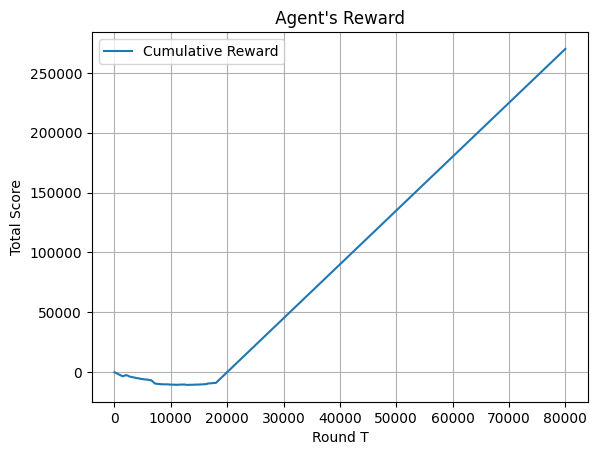

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def play_a_game(env: Env, agent: Agent, opponent:Agent, threshold=False, t = None, disp = False, full_stages=False):
    games = 0
    total_reward = 0

    if(t>20_000 ):
        agent.reduce_a()


    while True: #play as many hands until one player bankrupts
        state, *_ = env.reset(disp = disp)
        if(isinstance(opponent, Human_Agent)):
            #prints in order to inform the human agent
            print("---------------------New Hand--------------------")
            print(f"Human_agent's total money{env.game.total_money_per_player[1]}")
            print(f"Q_learning_agent's total money{env.game.total_money_per_player[0]}")
        if(not isinstance(opponent, Random_Agent)): opponent.set_hand(env.game.hand_of_player[1])
        games += 1
        if state == -1: return total_reward #means that the game has ended
        state = convert_pre_flop_state_to_num(state[0:5]) if not threshold else threshold_convert_state_to_num(state)
        preflop_state = state
        done = False
        mana = env.mana
        #for q_learning
        prev_state = state
        action = None
        reward = 0
        done = False
        round = 1
        while not done: #playing one hand
            #remember that state, reward an done are referring only in the agent
            round = (round + 1 )%2
            if (not isinstance(opponent, Random_Agent)): #instance of human or threshold agent
                opponent.set_round(round)
                opponent.set_table(env.game.table)
            previous_tuple = [prev_state, action, reward, state, done]

            if mana == 0: #if our agent is the mana
                prev_state = state
                action = agent.send_action(state)
                if (isinstance(opponent, Human_Agent)): print(f"q learning agent's action is {action}")
                state, reward, done=env.step(action, 0, t, previous_tuple, threshold=threshold, agent=agent)
                state = return_state(state, threshold, agent,preflop_state, full_stages=full_stages)
                if isinstance(agent, Q_Learning_Agent):#Agent is training after its turn
                    agent.train([prev_state, action, reward, state, done])

                total_reward += reward
                if done: break
                state, reward, done = env.step(opponent.send_action(state), 1, t, previous_tuple, threshold=threshold, agent=agent)
                state = return_state(state, threshold, agent,preflop_state,full_stages=full_stages)
                total_reward += reward
                if done: break

            else:

                state, reward, done=env.step(opponent.send_action(state), 1, t, previous_tuple, threshold=threshold, agent=agent)
                state = return_state(state, threshold, agent,preflop_state,full_stages=full_stages)
                prev_state = state
                total_reward += reward
                if done: break
                action = agent.send_action(state)
                if (isinstance(opponent, Human_Agent)): print(f"q learning agent's action is {action}")
                state, reward, done=env.step(action, 0, t, previous_tuple, threshold=threshold, agent=agent)
                state = return_state(state, threshold, agent,preflop_state,full_stages=full_stages)
                if isinstance(agent, Q_Learning_Agent):#Agent is training after its turn
                    agent.train([prev_state, action, reward, state, done])

                total_reward += reward
                if done: break

            if round == 0:#time to inform the opponents about the cards on the table
                env.game.table = [env.game.dealer.deal_card(),env.game.dealer.deal_card()]
                #i have to update in this step the state
                state = env.form_state()
                state = return_state(state, threshold, agent,preflop_state,full_stages=full_stages)



def training_main(threshold, q_learning, aggressive):
    threshold = threshold
    q_learning = q_learning
    p = P_THRESHOLD_A if threshold and aggressive else \
                (P_THRESHOLD_D if threshold and not aggressive else P)
    seed = 15
    np.random.seed(seed)
    gamma = .9
    agent = Q_Learning_Agent(   #state_size=2**10,
                                state_size=20 if not threshold else 33,
                                action_size= 3,
                                a=.4 ,
                                gamma=gamma,
                                against_human = False) if q_learning else \
                                PolicyIterationAgent(P=p, gamma=gamma)
    if threshold :
        opponent = Threshold_Agent_A() if aggressive else Threshold_Agent_D()
    else:
        opponent = Random_Agent(seed = seed)
        aggressive = False #just for constistency in the csv data

    horizon = 80_000

    env = Env(agent, opponent, number_of_cards=5, seed=np.random.randint(low=1, high = horizon))
    r = np.zeros(horizon)
    reward = np.zeros(horizon)

    for t in tqdm(range(horizon), desc="Processing items", unit="item"):

        reward[t] = play_a_game(env,agent,opponent, threshold=threshold, t=t, disp = False, full_stages=False)
        r[t] = reward[t]+r[t-1]*(t>0)
        s = np.random.randint(low = 1, high = horizon) #new seed in order to play a different sequence of card in every episode
        env = Env(agent, opponent, number_of_cards=5, seed=s)

    print(f"Total reward mean for the last 1000 iterations is {np.mean(reward[-1:-1000:-1])}")
    #data saving for report
    #saving the policy
    if not q_learning:
        decisions = list([agent.pi(i) for i in range(33 if threshold else 20)])
        np.savetxt(f"./data/q_learning_{ q_learning}_threshold_{threshold}_aggressive_{aggressive}.csv", decisions)
    else:
        decisions = list([np.argmax(agent.Q[i,:]) for i in range(33 if threshold else 20)])
        np.savetxt(f"./data/q_learning_{ q_learning}_threshold_{threshold}_aggressive_{aggressive}.csv", decisions)
        np.savetxt("./data/q_agent.csv", agent.Q, delimiter = ',')
    #saving the reward in order to plot it
    np.savetxt(f"./data/rewards/q_learning_{ q_learning}_threshold_{threshold}_aggressive_{aggressive}.csv", r)

    #kind of debugging plots
    plt.figure(1)
    plt.title(f" Agent's Reward ")
    plt.xlabel("Round T")
    plt.ylabel("Total Score")
    plt.plot(np.arange(1,horizon+1),r, label="Cumulative Reward")
    plt.grid()
    plt.legend()
    plt.savefig(f'images/q_learning_{ q_learning}_threshold_{threshold}_aggressive_{aggressive}.jpg')

    plt.show()


def testing_main():

    """ Method that tests the pre-trained learning agent against a human"""

    horizon = 2
    #loading the pre-trained agent
    q = np.loadtxt("./data/q_agent.csv", delimiter=",",dtype = float)
    agent = Q_Learning_Agent(state_size = 33, action_size = 2, Q = q, against_human=True )

    opponent = Human_Agent(action_size=2)
    env = Env(agent, opponent, number_of_cards=5, seed=np.random.randint(low=1, high = horizon))

    #It follows the same implementation as the training algorithm
    r = np.zeros(horizon)
    reward = np.zeros(horizon)
    for t in tqdm(range(horizon), desc= "Processing items", unit = "item"):

        reward[t] = play_a_game(env,agent,opponent, threshold=threshold, t=t, disp= True)
        r[t] = reward[t]+r[t-1]*(t>0)
        s = np.random.randint(low = 1, high = horizon)
        env = Env(agent, opponent, number_of_cards=5, seed=s)

if __name__ == "__main__":

    q_learning = True #Use a q-learning agent or not
    threshold = True #Use a threshold or a random opponent
    aggressive = True #in case of threshold, use aggressive or defensive opponent
    train = True
    if(train):training_main(threshold = threshold, q_learning = q_learning, aggressive = aggressive)
    else: testing_main()
